In [2]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
import pickle
import numpy as np
from datasets_batched import NUS_WIDE_KNN
from torchvision import transforms
import torchvision as tv
import csv

# Preparation

In [3]:
# loading pretrained model
model = pickle.load(open("pickles/models/entire_nuswide_model_2.p", "rb"))
word2vec_dict = pickle.load(open("pickles/word_embeddings/word_embeddings_tensors.p", "rb"))

# loading up filtered_text labels:
with open('labels.csv') as f:
    reader = csv.reader(f)
    NUS_WIDE_classes = [i[0] for i in list(reader)]
        
# init dataset
mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
data_path = 'NUS_WIDE'

dataset = NUS_WIDE_KNN(data_path,
    transforms.Compose([tv.transforms.Resize((224,224)), transforms.ToTensor(),
                                 transforms.Normalize(mean,std)]), NUS_WIDE_classes)

# Making database for FAISS index

In [4]:
def make_db(model):
    n = len(word2vec_dict)
    d = 30 # size of embeddings outputted by the model
    
    faiss_db = np.empty((n,d), dtype='float32')
    fidx_to_word = [None] * n
    model.eval()
    
    n_idx = 0
    for fidx, (key, value) in enumerate(word2vec_dict.items()):
        with torch.no_grad():
            embedding = model.get_embedding_word(value.unsqueeze(0).cuda()).data.cpu().numpy()
        faiss_db[fidx, :] = embedding
        fidx_to_word[fidx] = key
    
    return faiss_db, fidx_to_word

In [5]:
word_vec_db, idx_to_word = make_db(model)

# Inference

In [6]:
import faiss
index = faiss.IndexFlatL2(30)
index.add(word_vec_db)

In [11]:
def get_tags(im_idx, k=10):
    raw_image = dataset.get_raw_image(im_idx)
    image = dataset[im_idx][0]
    
    with torch.no_grad():
        embedded_image = model.get_embedding(image.unsqueeze(0).cuda()).data.cpu().numpy()
    
    query = np.asarray(embedded_image)
    _, indices = index.search(query, k)
    
    plt.figure()
    plt.imshow(raw_image)
    for idx in indices[0,:]:
        print(idx_to_word[idx])

buildings
council
town
square
utility
scenery
tower
window
courthouse
highways


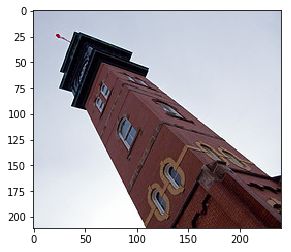

In [61]:
get_tags(np.random.randint(250000))